# Create and run local Rag pipeline from scratch 
chatting with pdf




In [1]:
import torch 

In [2]:
# Checking if GPU is available
!nvidia-smi

Wed Apr 30 16:44:02 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.18                 Driver Version: 546.18       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   47C    P8               1W /  66W |      0MiB /  6141MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Document processing 
# steps 
 1: Import PDF documents
 2: process text for embeding 
 3: embed text chunk with embedding model 
 4: save embeddings to file for later


In [3]:
import os 
import requests

# get pdf 
pdf_path = "human-nutrition-text.pdf"

# download PDF
if not os.path.exists(pdf_path):
    print(f"[INFO] file doesn't exists, downloading...")

    # Enter the url of the pdf 
    url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

    # the local filename to save the downloaded file 
    filename = pdf_path

    # send a get request to the url
    response = requests.get(url)

    # check if the requests was succesfull
    if response.status_code == 200:
        with open(filename, 'wb') as file:
            file.write(response.content)
        print(f"[INFO] the file has been downloaded and save as {filename}")
    else:
        print(f"[INFO] failed to download the file. status code: {response.status_code}")
else:
    print(f"File {pdf_path} exist")
    


[INFO] file doesn't exists, downloading...
[INFO] the file has been downloaded and save as human-nutrition-text.pdf


In [4]:
import fitz
from tqdm.auto import tqdm 

def text_formatter(text: str) -> str:
    """Perform minot formatting on text"""
    cleaned_text = text.replace("\n", " ").strip()

    # potentially more text formatting can go here 
    return cleaned_text
    
def open_and_read_pdf(pdf_path: str) -> list[dict]:
    doc = fitz.open(pdf_path)
    pages_and_texts = []
    for page_number, page  in tqdm(enumerate(doc)):
        text = page.get_text()
        text = text_formatter(text)
        pages_and_texts.append({"page_number": page_number - 41,
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text)/4,
                                "text": text}) 
        
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path)
print(pages_and_texts[:3])
        

0it [00:00, ?it/s]

[{'page_number': -41, 'page_char_count': 29, 'page_word_count': 4, 'page_sentence_count_raw': 1, 'page_token_count': 7.25, 'text': 'Human Nutrition: 2020 Edition'}, {'page_number': -40, 'page_char_count': 0, 'page_word_count': 1, 'page_sentence_count_raw': 1, 'page_token_count': 0.0, 'text': ''}, {'page_number': -39, 'page_char_count': 320, 'page_word_count': 54, 'page_sentence_count_raw': 1, 'page_token_count': 80.0, 'text': 'Human Nutrition: 2020  Edition  UNIVERSITY OF HAWAI‘I AT MĀNOA  FOOD SCIENCE AND HUMAN  NUTRITION PROGRAM  ALAN TITCHENAL, SKYLAR HARA,  NOEMI ARCEO CAACBAY, WILLIAM  MEINKE-LAU, YA-YUN YANG, MARIE  KAINOA FIALKOWSKI REVILLA,  JENNIFER DRAPER, GEMADY  LANGFELDER, CHERYL GIBBY, CHYNA  NICOLE CHUN, AND ALLISON  CALABRESE'}]


In [5]:
import random 
# random.sapmle(pages_and_texts, k=3)

In [6]:
import pandas as pd 
df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,147,3,199.25,Contents Preface University of Hawai‘i at Mā...


In [7]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00
std,348.86,560.38,95.83,6.55,140.10
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,762.00,134.00,5.00,190.50
50%,562.50,1231.50,216.00,10.00,307.88
75%,864.25,1603.50,272.00,15.00,400.88
max,1166.00,2308.00,430.00,39.00,577.00


# further text preproccessing  

In [8]:
# chunking the texts 
# 1.splitting by the fullstop
# 2.using nlp libraries like nltk and spacy 

from spacy.lang.en import English 

nlp = English()

# add a sentecizer pipline, see spacy sentecizer

nlp.add_pipe("sentencizer")

######################################
# create document instances as an example
doc = nlp("this is a sencentec. this is another sencence. I like elphant")
assert len(list(doc.sents)) == 3

list(doc.sents)
#######################################



[this is a sencentec., this is another sencence., I like elphant]

In [9]:
pages_and_texts[600]

{'page_number': 559,
 'page_char_count': 863,
 'page_word_count': 138,
 'page_sentence_count_raw': 9,
 'page_token_count': 215.75,
 'text': 'Image by  Allison  Calabrese /  CC BY 4.0  Korsakoff syndrome can cause similar symptoms as beriberi such  as confusion, loss of coordination, vision changes, hallucinations,  and may progress to coma and death. This condition is specific  to alcoholics as diets high in alcohol can cause thiamin deficiency.  Other individuals at risk include individuals who also consume diets  typically low in micronutrients such as those with eating disorders,  elderly, and individuals who have gone through gastric bypass  surgery.5  Figure 9.10 The Role of Thiamin  Figure 9.11 Beriberi, Thiamin Deficiency  5. Fact Sheets for Health Professionals: Thiamin. National  Institute of Health, Office of Dietary Supplements.   https://ods.od.nih.gov/factsheets/Thiamin- HealthProfessional/. Updated Feburary 11, 2016.  Accessed October 22, 2017.  Water-Soluble Vitamins  | 

In [10]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)

    # make sure all sentences are strings (default type is a spacy datatype)
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    # count the sentences 
    item["page_sentence_count_spacy"] = len(item["sentences"])

    # count 
    
    

  0%|          | 0/1208 [00:00<?, ?it/s]

In [11]:
random.sample(pages_and_texts, k=2)

[{'page_number': 231,
  'page_char_count': 1425,
  'page_word_count': 245,
  'page_sentence_count_raw': 16,
  'page_token_count': 356.25,
  'text': 'Carbohydrat es are broken  down into  the  subgroups  simple and  complex  carbohydrate s. These  subgroups  are further  categorized  into mono-,  di-, and  polysacchari des.  indigestible carbohydrates provide a good amount of fiber with a  host of other health benefits.  Plants synthesize the fast-releasing carbohydrate, glucose, from  carbon dioxide in the air and water, and by harnessing the sun’s  energy. Recall that plants convert the energy in sunlight to chemical  energy in the molecule, glucose. Plants use glucose to make other  larger, more slow-releasing carbohydrates. When we eat plants we  harvest the energy of glucose to support life’s processes.  Figure 4.1 Carbohydrate Classification Scheme  Carbohydrates are a group of organic compounds containing a ratio  of one carbon atom to two hydrogen atoms to one oxygen atom.  Basi

In [12]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00,10.32
std,348.86,560.38,95.83,6.55,140.10,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.00,134.00,5.00,190.50,5.00
50%,562.50,1231.50,216.00,10.00,307.88,10.00
75%,864.25,1603.50,272.00,15.00,400.88,15.00
max,1166.00,2308.00,430.00,39.00,577.00,28.00


### Chunking our sentences together 
the concept of splitting larger pieces of text into smaller ones is often referred 
to as text splitting or chunking 
there is no 100% correct way to do this 
we will keep it simple and split into group of 10 sentences(however, you could also try 5, 7, 8, whatever is believed good)

why we do this 
1. so our texts are esiear to filter (smaller groups of text can be easier to inspect that larger passages of text).
2. so our text chunks can fir into our embedding model context window (eg. 384 tokens as a limit).
3. so our conexts passed to an LLM


In [13]:
# Define split size to turn groups of sentences into chunks 
# Create a function to split lists of texts recursively into chunk size
num_sentence_chunk_size = 10

def split_list(input_list: list[str],slice_size: int=num_sentence_chunk_size) -> list[list[str]]:
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

test_list=list(range(25))
split_list(test_list)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [14]:
# loop through pages and texts and split sentences into chunks 

for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                        slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [15]:
random.sample(pages_and_texts, k=2)

[{'page_number': 1014,
  'page_char_count': 1361,
  'page_word_count': 226,
  'page_sentence_count_raw': 12,
  'page_token_count': 340.25,
  'text': 'on food. The FDA analyzes food for surface residue and waxes.  Processing methods can either reduce or concentrate pesticide  residue in foods. Therefore, the Food Quality Protection Act, which  was passed in 1996, requires manufacturers to show that pesticide  levels are safe for children.  Efforts within the Food Industry  The Hazard Analysis Critical Control Points (HACCP) is a program  within the food industry designed to promote food safety and  prevent contamination by identifying all areas in food production  and retail where contamination could occur. Companies and  retailers determine the points during processing, packaging,  shipping, or shelving where potential contamination may occur..  Those companies or retailers must then establish critical control  points to prevent, control, or eliminate the potential for food  contaminat

In [16]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00,10.32,1.53
std,348.86,560.38,95.83,6.55,140.10,6.30,0.64
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,260.75,762.00,134.00,5.00,190.50,5.00,1.00
50%,562.50,1231.50,216.00,10.00,307.88,10.00,1.00
75%,864.25,1603.50,272.00,15.00,400.88,15.00,2.00
max,1166.00,2308.00,430.00,39.00,577.00,28.00,3.00


### splitting each chunk into its own item
we'd like to embed each chunks of sentences into its own numerical represenattion
That'll give us a good level of granularity
Meaning, we can dive specifically into the text sample that was used in our model

In [17]:
import re 
# split each chunk into its item 
pages_and_chunks = []

for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        # join the sentences together into a paragraph-like structure, aka join the list of sentences into one paragraph
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'\1', joined_sentence_chunk) # ".A" -> ". A" (will work for any capital letter)


        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get some stats on our chunks 
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4  # 1 token ~=4 chars

        pages_and_chunks.append(chunk_dict)

len(pages_and_chunks)



  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [18]:
random.sample(pages_and_chunks, k=1)

[{'page_number': 801,
  'sentence_chunk': 'Updated April 2019Accessed April 25, 2020. Physical Activity during Pregnancy For most pregnant women, physical activity is a must and is recommended in the 2015-2020 Dietary Guidelines for Americans and the 2018 Physical Activity Guidelines for Americans 10. Regular exercise of moderate intensity, about thirty minutes per day most 10.-US. Department of Health and Human Services. (2018) Physical Activity Guidelines for Americans, 2nd edition. US. Department of Health and Human Services Pregnancy | 801',
  'chunk_char_count': 506,
  'chunk_word_count': 74,
  'chunk_token_count': 126.5}]

In [19]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,726.99,109.19,181.75
std,347.79,443.67,69.34,110.92
min,-41.00,12.00,3.00,3.00
25%,280.50,309.50,43.00,77.38
50%,586.00,742.00,111.00,185.50
75%,890.00,1105.00,168.00,276.25
max,1166.00,1816.00,290.00,454.00


In [20]:
df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count
0,-41,Human Nutrition: 2020 Edition,29,4,7.25
1,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00
2,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50
3,-37,Contents Preface University of Hawai‘i at Māno...,764,115,191.00
4,-36,Lifestyles and Nutrition University of Hawai‘i...,937,142,234.25


In [21]:
# filtering the text data more 
# show random chunks with under 30 tokens 
min_token_length = 30 
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f"Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}")

Chunk token count: 9.25 | Text: PART XIX APPENDICES Appendices | 1149
Chunk token count: 18.75 | Text: Published February 6, 2018. Accessed April 15, 2018. Comparing Diets | 1055
Chunk token count: 27.0 | Text: Iron Status and ExerciseThe American Journal of Clinical Nutrition, 72(2), 594S–597S. Sports Nutrition | 967
Chunk token count: 20.75 | Text: Centers for Disease Control and Prevention.http://www.cdc.gov/nutrition/ Iron | 661
Chunk token count: 17.75 | Text: http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=364  630 | Calcium


In [22]:
# filter our data frame for rows under 30 token
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5}]

In [23]:
random.sample(pages_and_chunks_over_min_token_len, k=1)

[{'page_number': 1030,
  'sentence_chunk': 'The Effect of New Technologies UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM AND HUMAN NUTRITION PROGRAM As mentioned earlier, new technology has had a tremendous effect on the food we eat and the customs and culture related to food consumptionFor example, microwaves are used to reduce cooking time or to heat up leftover foodRefrigerators and freezers allow produce to travel great distances and last longerOn the extreme end of making food last longer, there is special food for astronauts that is appropriate for consumption in spaceIt is safe to store, easy to prepare in the low-gravity environment of a spacecraft, and contains balanced nutrition to promote the health of people working in spaceIn the military, soldiers consume Meals Ready-to- Eat (MREs), which contain an entire meal in a single pouch. Consumer Info About Food From Genetically Engineered Plants FDA regulates the safety of food for humans and animals, i

In [24]:
# Embedding our text chunks which is a usefull numericcal representation
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path = "all-mpnet-base-v2",
                                     device="cpu")

# Creating a demo sentences embedding
sentences = ["the sentence transformer library provides an easy way to create embeddings",
           "sentence can be embedded one by one or in a list",
           "I like horses"]

# sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

for sentences, embeddings in embeddings_dict.items():
    print(f"Sentences: {sentences}")
    print(f"Embeddings: {embeddings}")
    print("\n")
 

Sentences: the sentence transformer library provides an easy way to create embeddings
Embeddings: [-3.17512788e-02  3.37267555e-02 -2.52437796e-02  5.22288419e-02
 -2.35249791e-02 -6.19116891e-03  1.35025457e-02 -6.25501350e-02
  7.50831934e-03 -2.29684897e-02  2.98145972e-02  4.57555614e-02
 -3.26700620e-02  1.39847612e-02  4.18013632e-02 -5.92969507e-02
  4.26310077e-02  5.04655251e-03 -2.44552530e-02  3.98591487e-03
  3.55898216e-02  2.78742742e-02  1.84098873e-02  3.67699228e-02
 -2.29961611e-02 -3.01796887e-02  5.99619874e-04 -3.64504606e-02
  5.69104776e-02 -7.49941776e-03 -3.70004103e-02 -3.04364343e-03
  4.64355052e-02  2.36149481e-03  9.06849550e-07  7.00036297e-03
 -3.92289162e-02 -5.95697155e-03  1.38653331e-02  1.87106046e-03
  5.34202717e-02 -6.18613772e-02  2.19613519e-02  4.86051328e-02
 -4.25697267e-02 -1.69858467e-02  5.04178256e-02  1.54733518e-02
  8.12860429e-02  5.07106557e-02 -2.27496810e-02 -4.35721017e-02
 -2.18382338e-03 -2.14091577e-02 -2.01758258e-02  3.06832

In [25]:
embeddings[:].shape

(768,)

In [26]:
embedding = embedding_model.encode("My favorite animal is the cow")
embedding

array([-1.09388437e-02,  8.82674158e-02, -2.37648841e-02, -3.54011171e-02,
        2.74386778e-02,  6.17905520e-02, -7.10514337e-02,  1.02041941e-02,
        5.09820459e-03, -2.54746228e-02, -2.99266558e-02,  4.24541533e-02,
       -2.68460307e-02, -1.12865884e-02, -7.95944780e-03, -4.00728546e-02,
        3.31865773e-02,  8.96498188e-03, -1.39676435e-02,  3.90812159e-02,
       -2.44889520e-02,  4.66110483e-02, -1.27316657e-02, -2.28750128e-02,
       -1.59286205e-02,  9.13770683e-03, -4.58197296e-03, -3.16689014e-02,
        1.96867436e-02,  2.20827498e-02, -5.99105470e-02, -8.53317976e-02,
        2.50547975e-02, -2.33548190e-02,  1.26535804e-06,  4.64817835e-03,
       -3.16274092e-02,  1.34030888e-02,  4.78031375e-02, -2.65758741e-03,
        8.82108603e-03,  7.97377434e-03, -2.19644196e-02,  1.81926340e-02,
        1.84454806e-02,  5.86614758e-02,  4.57940176e-02,  1.97309051e-02,
       -9.53952074e-02,  2.15807054e-02, -2.76751094e-03, -1.23229586e-02,
       -3.21626216e-02,  

In [27]:
%%time 
embedding_model.to('cuda')
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/1677 [00:00<?, ?it/s]

CPU times: total: 1min 18s
Wall time: 1min 20s


In [28]:
%%time 

text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]
text_chunks[419]

CPU times: total: 0 ns
Wall time: 0 ns


'often. • Calm your “sweet tooth” by eating fruits, such as berries or an apple. • Replace sugary soft drinks with seltzer water, tea, or a small amount of 100 percent fruit juice added to water or soda water. The Food Industry: Functional Attributes of Carbohydrates and the Use of Sugar Substitutes In the food industry, both fast-releasing and slow-releasing carbohydrates are utilized to give foods a wide spectrum of functional attributes, including increased sweetness, viscosity, bulk, coating ability, solubility, consistency, texture, body, and browning capacityThe differences in chemical structure between the different carbohydrates confer their varied functional uses in foods. Starches, gums, and pectins are used as thickening agents in making jam, cakes, cookies, noodles, canned products, imitation cheeses, and a variety of other foodsMolecular gastronomists use slow- releasing carbohydrates, such as alginate, to give shape and texture to their fascinating food creationsAdding fi

In [29]:
len(text_chunks)


1677

In [30]:
%%time 

# embedd all texts in batches 

text_chunk_embeddings = embedding_model.encode(text_chunks, 
                                              batch_size=32,
                                              convert_to_tensor=True)
text_chunk_embeddings 


CPU times: total: 20.1 s
Wall time: 19.5 s


tensor([[ 0.0674,  0.0902, -0.0051,  ..., -0.0221, -0.0232,  0.0126],
        [ 0.0552,  0.0592, -0.0166,  ..., -0.0120, -0.0103,  0.0227],
        [ 0.0273,  0.0341, -0.0216,  ..., -0.0042,  0.0216,  0.0323],
        ...,
        [ 0.0693,  0.0198, -0.0020,  ..., -0.0394, -0.0719, -0.0258],
        [ 0.1043, -0.0206,  0.0128,  ..., -0.0516, -0.0209, -0.0251],
        [ 0.0368, -0.0261, -0.0242,  ..., -0.0327, -0.0262, -0.0175]],
       device='cuda:0')

In [31]:
pages_and_chunks_over_min_token_len[419]

{'page_number': 277,
 'sentence_chunk': 'often. • Calm your “sweet tooth” by eating fruits, such as berries or an apple. • Replace sugary soft drinks with seltzer water, tea, or a small amount of 100 percent fruit juice added to water or soda water. The Food Industry: Functional Attributes of Carbohydrates and the Use of Sugar Substitutes In the food industry, both fast-releasing and slow-releasing carbohydrates are utilized to give foods a wide spectrum of functional attributes, including increased sweetness, viscosity, bulk, coating ability, solubility, consistency, texture, body, and browning capacityThe differences in chemical structure between the different carbohydrates confer their varied functional uses in foods. Starches, gums, and pectins are used as thickening agents in making jam, cakes, cookies, noodles, canned products, imitation cheeses, and a variety of other foodsMolecular gastronomists use slow- releasing carbohydrates, such as alginate, to give shape and texture to t

In [32]:
# save embeddings to file 
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path)

In [33]:
# Import saved file and view 
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,Unnamed: 0,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242601e-02 9.02280882e-02 -5.09548374e-...
1,1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 5.52156232e-02 5.92139289e-02 -1.66167244e-...
2,2,-37,Contents Preface University of Hawai‘i at Māno...,764,115,191.00,[ 2.73287948e-02 3.40599343e-02 -2.15530694e-...
3,3,-36,Lifestyles and Nutrition University of Hawai‘i...,937,142,234.25,[ 6.77905381e-02 4.26554643e-02 -7.37826619e-...
4,4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264382e-02 -8.49766470e-03 9.57158953e-...


In [34]:
# if your embedding database is really large (e.g. over 100k-1M samples) you might want to look into using a vector database for search
# Searching for a relevant documents i.e similarity search
# Embeddings can be used almost for any type of data (e.g images, audio, text and on and on)

import random 
import numpy as np
import pandas as pd

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Import texts and embeddings 
text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embedding columns back to np.array
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert our embeddings into a torch tensor
embeddings = torch.tensor(np.stack(text_chunks_and_embedding_df["embedding"].tolist(), axis=0), dtype=torch.float32).to(device)

# Convert texts and embeddings df 
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

text_chunks_and_embeddings_df 


,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,"[0.06742426, 0.09022809, -0.0050954837, -0.031..."
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,"[0.055215623, 0.05921393, -0.016616724, -0.020..."
2,-37,Contents Preface University of Hawai‘i at Māno...,764,115,191.00,"[0.027328795, 0.034059934, -0.02155307, -0.001..."
3,-36,Lifestyles and Nutrition University of Hawai‘i...,937,142,234.25,"[0.06779054, 0.042655464, -0.007378266, -0.015..."
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,"[0.03302644, -0.008497665, 0.0095715895, -0.00..."
...,...,...,...,...,...,...
1672,1164,Flashcard Images Note: Most images in the flas...,1290,179,322.50,"[0.024319079, -0.021271434, -0.013849775, -0.0..."
1673,1164,Hazard Analysis Critical Control Points reused...,370,49,92.50,"[0.042931683, -0.064712465, 0.020520769, -0.00..."
1674,1165,ShareAlike 11Organs reused “Pancreas Organ Ana...,1267,166,316.75,"[0.06930764, 0.019757757, -0.001999006, 0.0035..."
1675,1165,Sucrose reused “Figure 03 02 05” by OpenStax B...,406,61,101.50,"[0.10429635, -0.020631257, 0.0127973, 0.024155..."


In [35]:
embeddings.shape

torch.Size([1677, 768])

In [36]:
# Create embedding model 
from time import perf_counter as timer 
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                     device = device)

# 1. Define the query
query = "macronutrients functions"
print(f"Query: {query} ")

# 2. Embed the query
query_embedding = embedding_model.encode(query, convert_to_tensor=True).to("cuda")

# 3. Get similaarity scores with the dot product(use cosine similaryt search)
# To use the dot product the dtype and shape must much!

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds")

# 4. Get the top k e.g top five
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product



Query: macronutrients functions 
[INFO] Time taken to get scores on 1677 embeddings: 0.00161 seconds


torch.return_types.topk(
values=tensor([0.6906, 0.6591, 0.6578, 0.6550, 0.6502], device='cuda:0'),
indices=tensor([42, 46, 47, 41, 51], device='cuda:0'))

In [37]:
# helper function for a better output display

import textwrap 

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)
    

In [38]:
pages_and_chunks[42]

{'Unnamed: 0': 42,
 'page_number': 5,
 'sentence_chunk': 'Macronutrients Nutrients that are needed in large amounts are called macronutrientsThere are three classes of macronutrients: carbohydrates, lipids, and proteinsThese can be metabolically processed into cellular energyThe energy from macronutrients comes from their chemical bondsThis chemical energy is converted into cellular energy that is then utilized to perform work, allowing our bodies to conduct their basic functionsA unit of measurement of food energy is the calorieOn nutrition food labels the amount given for “calories” is actually equivalent to each calorie multiplied by one thousandA kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with the “Calorie” (with a capital “C”) on nutrition food labelsWater is also a macronutrient in the sense that you require a large amount of it, but unlike the other macronutrients, it does not yield calories. Carbohydrates Carbohydrates are molecules composed of 

In [39]:
larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)
print(f"Embedding shape is: {larger_embeddings.shape}")

start_time = timer()
dot_score = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()

print(f"[INFO] Time taken to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds")


Embedding shape is: torch.Size([167700, 768])
[INFO] Time taken to get scores on 167700 embeddings: 0.01145 seconds


In [40]:
query = "macronutrients functions"
print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indices from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    print("Text")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    print(f"page number: {pages_and_chunks[idx]["page_number"]}")
    print("\n")

Query: 'macronutrients functions'

Results:
Score: 0.6906
Text
Macronutrients Nutrients that are needed in large amounts are called
macronutrientsThere are three classes of macronutrients: carbohydrates, lipids,
and proteinsThese can be metabolically processed into cellular energyThe energy
from macronutrients comes from their chemical bondsThis chemical energy is
converted into cellular energy that is then utilized to perform work, allowing
our bodies to conduct their basic functionsA unit of measurement of food energy
is the calorieOn nutrition food labels the amount given for “calories” is
actually equivalent to each calorie multiplied by one thousandA kilocalorie (one
thousand calories, denoted with a small “c”) is synonymous with the “Calorie”
(with a capital “C”) on nutrition food labelsWater is also a macronutrient in
the sense that you require a large amount of it, but unlike the other
macronutrients, it does not yield calories. Carbohydrates Carbohydrates are
molecules compose

We could potentially improve the order of these results by reranking model.


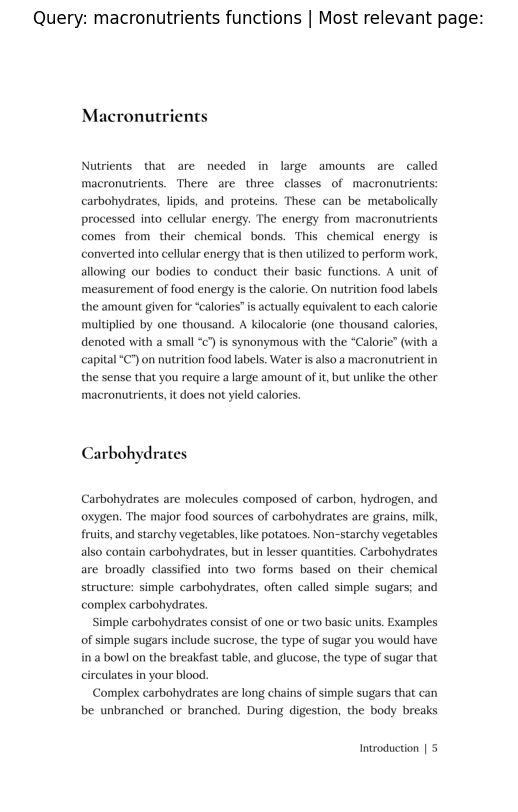

In [41]:
import fitz 
import matplotlib.pyplot as plt 
# open the pdf and load the target page 
pdf_path = "human-nutrition-text.pdf"
doc = fitz.open(pdf_path)
page = doc.load_page(5+41) # note page number of our PDF start 41+

# get the image of the page 
img = page.get_pixmap(dpi=300)
doc.close()

# save image of the paper
# img.save("output_filename.png")

# convert  the pixm to a numpy array 
img_array = np.frombuffer(img.samples_mv,
                         dtype=np.uint8).reshape((img.h, img.w, img.n))

# img_array
# display the image using matplotlib
plt.figure(figsize=(13,10))
plt.imshow(img_array)
plt.title(f"Query: {query} | Most relevant page:")
plt.axis("off")
plt.show()

In [42]:
# similarty search 
import torch 
def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)

    # Get Euclidean/L2 norm distance
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    # Get the cosine dot product
    cosine_dot_product = dot_product / (norm_vector1 * norm_vector2)
    
    return cosine_dot_product

# Example: vectors/tensors 

vector1 = torch.tensor([1,2,3], dtype=torch.float32)
vector2 = torch.tensor([1,2,3], dtype=torch.float32)
vector3 = torch.tensor([4,5,6], dtype=torch.float32)
vector4 = torch.tensor([-1,-2,-3], dtype=torch.float32)


# Calculate the dot product 
print("Dot product between vector1, and vector2:", dot_product(vector1, vector2))
print("Dot product between vector1, and vector3:", dot_product(vector1, vector3))
print("Dot product between vector1, and vector4:", dot_product(vector1, vector4))


# Cosine similarity
print("\n")
print("Cosine similarity between vector1, and vector2:", cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1, and vector3:", cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1, and vector4:", cosine_similarity(vector1, vector4))



Dot product between vector1, and vector2: tensor(14.)
Dot product between vector1, and vector3: tensor(32.)
Dot product between vector1, and vector4: tensor(-14.)


Cosine similarity between vector1, and vector2: tensor(1.0000)
Cosine similarity between vector1, and vector3: tensor(0.9746)
Cosine similarity between vector1, and vector4: tensor(-1.0000)


In [85]:
# Functinizing our semnatic search pipline 

def retrieve_relevant_resources(query: str, embeddings: torch.tensor, 
                              model: SentenceTransformer=embedding_model,
                              n_resources_to_return: int=5,
                              print_time: bool=True):
    """ 
    Embedds a query with embedding model and returns 
    top k scores and indices from embeddings.
    """
    # Embed the query 
    query_embedding = model.encode(query, convert_to_tensor=True)

    # Get the dot product on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds")

    scores, indices = torch.topk(dot_scores, k=n_resources_to_return)

    return scores, indices 

def print_top_results_and_scores(query: str, 
                                embeddings: torch.tensor,
                                pages_and_chunks: list[dict]=pages_and_chunks,
                                n_resources_to_return: int=5):
    """
    Finds relevant passages given a 
    query and prints them out along with their scores 
    """
    scores, indices = retrive_relevant_resources(query=query,
                                                embeddings=embeddings,
                                                n_resources_to_return=n_resources_to_return)

    # Loop through zipped together scores and indices from tourch.topk
    for score, idx in zip(scores, indices):
        print(f"Score: {score:.4f}")
        print("Text")
        print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
        print(f"page number: {pages_and_chunks[idx]["page_number"]}")
        print("\n")

In [86]:
query = "foods high in fiber"
retrieve_relevant_resources(query=query, embeddings=embeddings)

print_top_results_and_scores(query=query, embeddings=embeddings)

[INFO] Time taken to get scores on 1677 embeddings: 0.00045 seconds
[INFO] Time taken to get scores on 1677 embeddings: 0.00016 seconds
Score: 0.6964
Text
• Change it up a bit and experience the taste and satisfaction of other whole
grains such as barley, quinoa, and bulgur. • Eat snacks high in fiber, such as
almonds, pistachios, raisins, and air-popped popcorn. Add an artichoke and green
peas to your dinner plate more 276 | Carbohydrates and Personal Diet Choices
page number: 276


Score: 0.6798
Text
Dietary fiber is categorized as either water-soluble or insoluble. Some examples
of soluble fibers are inulin, pectin, and guar gum and they are found in peas,
beans, oats, barley, and ryeCellulose and lignin are insoluble fibers and a few
dietary sources of them are whole-grain foods, flax, cauliflower, and
avocadosCellulose is the most abundant fiber in plants, making up the cell walls
and providing structureSoluble fibers are more easily accessible to bacterial
enzymes in the large in

# Getting an LLM 

In [87]:
 # Get GPU availability memory 
import torch 

gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes/(2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 6 GB


In [88]:
# Note: the following is gemma focused, 
# however, there are more and more LLMs of the 2b and 7b size
# appearing for local use 

if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommende model: Gemma 2b in 4-bit precision")
    use_quantization_config = True
    model_id = "google/gemma-2-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommende model: Gemma 2b in float16 or 4-bit precision")
    use_quantization_config = False
    model_id = "google/gemma-2-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommende model: Gemma 7b in float16 or 4-bit precision")
    use_quantization_config = False
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

GPU memory: 6 | Recommende model: Gemma 2b in 4-bit precision
use_quantization_config set to: True
model_id set to: google/gemma-2-2b-it


In [89]:
!nvidia-smi

Wed Apr 30 08:17:16 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.18                 Driver Version: 546.18       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   36C    P8             588W /  35W |   5302MiB /  6141MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [48]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [49]:
#  loading an LLM locally
import os
import torch
from dotenv import load_dotenv
from huggingface_hub import login
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
)
from transformers.utils import is_flash_attn_2_available


# 00. Loading the environment variable
load_dotenv()

# 01. Grab token
hf_token = os.getenv("HF_TOKEN")
if not hf_token:
    raise RuntimeError("Hugging Face token not found! Please set HF_TOKEN in your .env file.")

# 02. (Optional) Cache it locally so you can also use CLI-backed commands
login(token=hf_token)

# 1.Create a quantization config

quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                        bnb_4bit_compute_dtype=torch.bfloat16,
                                        llm_int8_enable_fp32_cpu_offload=True)


# flash attention 2 - faster attention mechanism 
# Flash attention requires a GPU capability 8.0+
if (is_flash_attn_2_available()) and (torch_cuda.get_device_capability(0)[0] >=8):
    attn_implementation = "flash_attention_2" 
else:
    attn_implementation = "sdpa" # scaled dot product attention
# 2. Pick a model 
model_id = "google/gemma-2-2b-it"
model_id = model_id 

# 3. Instantiate tokenizer (tokenizer turns text into tokens)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id, 
                                          token=hf_token,)

# 4 Instantiate the model 
llm_model = AutoModelForCausalLM.from_pretrained(
     pretrained_model_name_or_path=model_id,
     device_map="auto",
     token=hf_token,
     torch_dtype=torch.float16,
     quantization_config=quantization_config if use_quantization_config else None,
     low_cpu_mem_usage=True,
     attn_implementation=attn_implementation,
)

if not use_quantization_config:
    llm_model.to("cuda")

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [51]:
print(f"Using attention implementation: {attn_implementation}")

Using attention implementation: sdpa


In [50]:
llm_model

Gemma2ForCausalLM(
  (model): Gemma2Model(
    (embed_tokens): Embedding(256000, 2304, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma2DecoderLayer(
        (self_attn): Gemma2Attention(
          (q_proj): Linear4bit(in_features=2304, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2304, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=2304, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2304, bias=False)
        )
        (mlp): Gemma2MLP(
          (gate_proj): Linear4bit(in_features=2304, out_features=9216, bias=False)
          (up_proj): Linear4bit(in_features=2304, out_features=9216, bias=False)
          (down_proj): Linear4bit(in_features=9216, out_features=2304, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (post_attention_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (pre_

In [55]:
# clculating model parameters 
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

print(f" The total model parameter is: {get_model_num_params(llm_model)}")

 The total model parameter is: 1602203904


In [62]:
def get_model_mem_size(model: torch.nn.Module):
    # Get model parameters 
    total_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    tota_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])
    
    #Calculate model sizes 
    model_mem_bytes = total_params + tota_buffers
    model_mem_mb = model_mem_bytes / (1024**2)
    model_mem_gb = model_mem_bytes / (1024**3)
    
    return {"model_mem_bytes" : model_mem_bytes,
            "model_mem_mb" : round(model_mem_mb, 2),
            "model_mem_gb" : round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 2192270336, 'model_mem_mb': 2090.71, 'model_mem_gb': 2.04}

# Generate text with our LLM

In [76]:
# input_text = "what are the macronutrients, and what are the roles do they play in human body"
input_text = "how long should infants be breastfed for"
print(input_text)

# Creating a prompt template for instruction tuned model

dialogue_template = [
    {
        "role": "user",
        "content": input_text
    }
]

prompt = tokenizer.apply_chat_template(conversation=dialogue_template, 
                                      tokenize=False,
                                      add_generation_prompt = True)

print(f"\nPrompt (formatted): \n{prompt}")

how long should infants be breastfed for

Prompt (formatted): 
<bos><start_of_turn>user
how long should infants be breastfed for<end_of_turn>
<start_of_turn>model



In [77]:
%%time 

#  Tokenize the input text (turn it into numbers) and send it to the GPU
input_ids = tokenizer(prompt, 
                     return_tensors="pt").to(device)

# Generate output from local LLMs
outputs = llm_model.generate(**input_ids, 
                            max_new_tokens = 256)

print(f"Model output (tokens): \n{outputs[0]}\n")

Model output (tokens): 
tensor([     2,      2,    106,   1645,    108,   1139,   1497,   1412,  45770,
           614,  14665,  30629,    604,    107,    108,    106,   2516,    108,
           651,   3855,   5101,  19847,    591,  38394, 235275,    578,    573,
          3725,  13322,    576, 125142,    591,  79569, 235275,   5656,  15587,
         84810,    604,    573,   1370,   4442,   4063,    576,    671,  31808,
        235303, 235256,   1913, 235265, 235248,    109,   4858, 235303, 235256,
           476,  25497,    576,  10064,  84810,  12317, 235292,    109,    688,
         79604,  84810,  66058,    109, 235287,   5231,   5546, 235248, 235318,
          4063,  66058, 149810,  10834,  14665,  24824, 235269,   6996,    793,
          1156,   2960,    689,   7182,   7694,  14665,   9512,    603,   2764,
        235265,    108, 235287,   5231,   2728,    577, 235248, 235274,   1162,
         66058,  31241,  84810,  22814,   6792,  16512, 235269,    901,   5374,
           577, 

In [78]:
# Decode the output tokens to text 

outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}")

Model output (decoded):
<bos><bos><start_of_turn>user
how long should infants be breastfed for<end_of_turn>
<start_of_turn>model
The World Health Organization (WHO) and the American Academy of Pediatrics (AAP) recommend exclusive breastfeeding for the first six months of an infant's life. 

Here's a breakdown of recommended breastfeeding practices:

**Exclusive breastfeeding:**

* **First 6 months:** Exclusively breastfeed, meaning no other food or drink except breast milk is given.
* **Up to 1 year:** Continue breastfeeding alongside solid foods, but continue to provide breast milk as the primary source of nutrition.

**Benefits of Breastfeeding:**

* **Nutritional benefits:** Breast milk provides optimal nutrition for infants, including antibodies, vitamins, minerals, and growth factors.
* **Health benefits:** Breastfeeding has been linked to a lower risk of:
    * Ear infections
    * Respiratory infections
    * Allergies
    * Sudden infant death syndrome (SIDS)
    * Obesity
    

In [80]:
# list of questions 

# Nutrition-style questions generated with GPT4
gpt4_questions = [
    "What are the macronutrients, and what roles do they play in the human body?",
    "How do vitamins and minerals differ in their roles and importance for health?",
    "Describe the process of digestion and absorption of nutrients in the human body.",
    "What role does fibre play in digestion? Name five fibre containing foods.",
    "Explain the concept of energy balance and its importance in weight management."
]

# Manually created question list
manual_questions = [
    "How often should infants be breastfed?",
    "What are symptoms of pellagra?",
    "How does saliva help with digestion?",
    "What is the RDI for protein per day?",
    "water soluble vitamins"
]

query_list = gpt4_questions + manual_questions
query_list

['What are the macronutrients, and what roles do they play in the human body?',
 'How do vitamins and minerals differ in their roles and importance for health?',
 'Describe the process of digestion and absorption of nutrients in the human body.',
 'What role does fibre play in digestion? Name five fibre containing foods.',
 'Explain the concept of energy balance and its importance in weight management.',
 'How often should infants be breastfed?',
 'What are symptoms of pellagra?',
 'How does saliva help with digestion?',
 'What is the RDI for protein per day?',
 'water soluble vitamins']

In [90]:
import random 
query = random.choice(query_list)
print(query)

# Get just the score and indices of top related results
scores, indices = retrieve_relevant_resources(query=query, 
                                              embeddings=embeddings)

scores, indices 

water soluble vitamins
[INFO] Time taken to get scores on 1677 embeddings: 0.00021 seconds


(tensor([0.7673, 0.7566, 0.7410, 0.6946, 0.6888], device='cuda:0'),
 tensor([800, 854, 755, 847, 754], device='cuda:0'))

# Augmenting our prompt with context

In [104]:
def prompt_formatter(query: str, context_items: list[dict]) -> str:
    context = "- " + "\n ".join([item["sentence_chunk"] for item in context_items])
   
    base_prompt = """Based on the following context items, please answer the query.
        Give yourself room to think by extracting relevant passages from the context before answering the query.
        Don't return the thinking, only return the answer.
        Make sure your answers are as explanatory as possible.
        Use the following examples as reference for the ideal answer style.
        \nExample 1:
        Query: What are the fat-soluble vitamins?
        Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.
        \nExample 2:
        Query: What are the causes of type 2 diabetes?
        Answer: Type 2 diabetes is often associated with overnutrition, particularly the overconsumption of calories leading to obesity. Factors include a diet high in refined sugars and saturated fats, which can lead to insulin resistance, a condition where the body's cells do not respond effectively to insulin. Over time, the pancreas cannot produce enough insulin to manage blood sugar levels, resulting in type 2 diabetes. Additionally, excessive caloric intake without sufficient physical activity exacerbates the risk by promoting weight gain and fat accumulation, particularly around the abdomen, further contributing to insulin resistance.
        \nExample 3:
        Query: What is the importance of hydration for physical performance?
        Answer: Hydration is crucial for physical performance because water plays key roles in maintaining blood volume, regulating body temperature, and ensuring the transport of nutrients and oxygen to cells. Adequate hydration is essential for optimal muscle function, endurance, and recovery. Dehydration can lead to decreased performance, fatigue, and increased risk of heat-related illnesses, such as heat stroke. Drinking sufficient water before, during, and after exercise helps ensure peak physical performance and recovery.
        \nNow use the following context items to answer the user query:
        {context}
        \nRelevant passages: <extract relevant passages from the context here>
        User query: {query}
        Answer:"""
    
    base_prompt = base_prompt.format(context=context, query=query)

    # Create Template for instruction tuned Model
    dialogue_template = [
        {
            "role": "user",
            "content": base_prompt
        }
    ]
    
    prompt = tokenizer.apply_chat_template(conversation = dialogue_template,
                                          tokenize = False,
                                          add_genetration_prompt = True)
    
    return prompt

query = random.choice(query_list)
print(f"Query: {query}")

# Get the relevant resources 
scores, indices = retrieve_relevant_resources(query=query, embeddings=embeddings)

# Create a list of context items 
context_items = [pages_and_chunks[i] for i in indices]
# Prompt formatter 
prompt = prompt_formatter(query=query,
                         context_items = context_items)

print(prompt)

Query: What are symptoms of pellagra?
[INFO] Time taken to get scores on 1677 embeddings: 0.00016 seconds
<bos><start_of_turn>user
Based on the following context items, please answer the query.
        Give yourself room to think by extracting relevant passages from the context before answering the query.
        Don't return the thinking, only return the answer.
        Make sure your answers are as explanatory as possible.
        Use the following examples as reference for the ideal answer style.
        
Example 1:
        Query: What are the fat-soluble vitamins?
        Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage

In [105]:
%%time 

input_ids = tokenizer(prompt, return_tensors="pt").to(device)

# Sentence on output of tokens 
outputs = llm_model.generate(**input_ids, 
                            temperature=0.7,
                            do_sample=True,
                            max_new_tokens=500)

# Turn the output tokens into text

output_text = tokenizer.decode(outputs[0])

print(f"Query: {query}")

print(f"RAG answer:\n{output_text.replace(prompt, '')}")

Query: What are symptoms of pellagra?
RAG answer:
<bos>
        Pellagra is commonly known as niacin deficiency, and its symptoms include fatigue, decreased appetite, and indigestion. These symptoms are then commonly followed by the four D’s: diarrhea, dermatitis, dementia, and sometimes death. 
        
    **Explanation:** 
    
    Niacin deficiency can lead to a variety of symptoms, which are collectively known as pellagra. The most common symptoms include fatigue, decreased appetite, and indigestion.
    
    * Fatigue:  A low niacin level can lead to fatigue, a common symptom associated with the deficiency. 
    * Decreased Appetite: Niacin is crucial for appetite regulation. Deficiency can lead to a decreased appetite.
    * Indigestion:  A niacin deficiency can also cause digestive issues due to its role in the breakdown of food.
 
Let me know if you'd like to explore other aspects of this passage!  



<end_of_turn>
CPU times: total: 28.4 s
Wall time: 30.5 s


In [116]:
# Functionize LLM answering feature 
def ask(query: str, temperature: float=0.7, max_new_tokens: int=256,
       format_answer_text=True, return_answer_only=True):

    """ 
    Takes a query, finds relevant resources/context and generation an answer
    to the query based on the relevant resources.
    """

    # Get just the scores and indices of the top related 
    scores, indices = retrieve_relevant_resources(query=query, 
                                                  embeddings=embeddings)

    # Create a list of context items 
    context_items = [pages_and_chunks[i] for i in indices]

    # Add score to context items 
    for i, items in enumerate(context_items):
        items["score"] = scores[i].cpu()

    # Augmentation 
    # Create the prompt and format it with context items 
    prompt = prompt_formatter(query=query, context_items=context_items)

    # Generation 
    # tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to(device)

    # Generate an output 
    outputs = llm_model.generate(**input_ids, 
                                 temperature=0.7,
                                do_sample=True,
                                max_new_tokens=max_new_tokens)
    # Decode the tokens 
    output_text = tokenizer.decode(outputs[0])

    # Format the answer
    if format_answer_text:
        # Replace prompt and special tokens 
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("<end_of_turn>", "")

    # Only return the answer without context items
    if return_answer_only:
        return output_text

    return output_text, context_items
    
    

In [121]:
query = random.choice(query_list)
print(f"Query: {query}")
ask(query, temperature=0.2, return_answer_only=True)

Query: Describe the process of digestion and absorption of nutrients in the human body.
[INFO] Time taken to get scores on 1677 embeddings: 0.00019 seconds


"  The digestive process begins even before you eat. Your body signals your brain that it's time to eat, and this triggers salivation to prepare for the meal. Once you eat, the digestive system starts breaking down food into smaller components. This happens on two levels: mechanically (moving and mixing food) and chemically (breaking down large molecules). These smaller nutrient molecules are then absorbed by the body's cells to be used for energy or building new cells. The body relies on nutrients such as carbohydrates, fats, and proteins to perform vital biological functions and maintain daily life processes. The nutrients reach the body through the small intestine, where they are absorbed into the blood and transported to the liver, where they are processed and distributed throughout the body. Water-soluble nutrients go directly to the liver via the portal vein, while lipids are transported via the lymphatic system to the liver for further processing. Finally, the absorbed component